## wPCC propeller model on the MDL data
As the thrust is not measured in the real environment with the 7m model, either an Abkowitz model - which models the entire ship system including propeller and rudder - or a modular model similar to the MMG model, with a hull, propeller, and rudder module is needed. In the presens of wind forces, the Abkowitz model is not so suitable, as it is hard to find a good model that can counteract the wind force, in head winds. Therefore a separate propeller model is instead developed.

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, track_plots, plot
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
#from vessel_manoeuvring_models.models.vmm_martin_simple import martins_simple_model as vmm
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator
from vessel_manoeuvring_models.models.propeller import *
from vessel_manoeuvring_models.prime_system import df_prime
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import statsmodels.api as sm
import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [4]:
%reload_kedro
ship='wPCC'
time_series = catalog.load(f"{ship}.time_series")
time_series_smooth = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)
model_loader = catalog.load(f"{ship}.models")
#time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)

[06/07/23 08:55:00] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=933551;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=63266;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[06/07/23 08:55:09] INFO     Kedro project phd                                                      ]8;id=38998;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=536715;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=785573;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=225017;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=447889;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=984637;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from 'wPCC.time_series' (PartitionedDataSet)...       ]8;id=292868;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=691257;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=720463;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=153895;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=300493;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=25180;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.exclude_parameters'                 ]8;id=750689;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=368638;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=916172;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=914073;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=30267;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=671166;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [5]:
eq_T

Eq(thrust_propeller, D**4*K_T*rev**2*rho)

In [6]:
eq_K_T

Eq(K_T, J**2*k_2 + J*k_1 + k_0)

In [7]:
eq_K_T_simple = sp.Eq(K_T, J*k_1 + k_0)
eq_K_T_simple

Eq(K_T, J*k_1 + k_0)

In [8]:
eq_J

Eq(J, u*(1 - w_p)/(D*rev))

In [9]:
eq_Q

Eq(torque_propeller, D**5*K_Q*rev**2*rho/eta_r)

In [10]:
eq_beta_p = sp.Eq(beta_p, beta - x_p/df_prime.loc['denominator','length'] * r/df_prime.loc['denominator','angular_velocity'])

In [11]:
eq_beta_p

Eq(beta_p, beta - r*x_r/U)

In [12]:
eqs = [
       eq_K_T_simple,
       eq_J,
      ]
solution = sp.solve(eqs, K_T, J)[K_T]
eq_KT_wp = sp.Eq(K_T, solution)
eq_KT_wp


Eq(K_T, (D*k_0*rev - k_1*u*w_p + k_1*u)/(D*rev))

## TT

In [13]:
df_resistance = pd.read_csv("TT_resistance.csv")
df_resistance

,VS,Vm,FnL,CTm*1000,CRm*1000,tm,wTm,ηRm,η0m
0,8,0.823,0.091,3.615,-0.014,0.084,0.129,0.957,0.673
1,10,1.029,0.114,3.526,0.039,0.072,0.123,0.961,0.674
2,12,1.235,0.137,3.523,0.147,0.112,0.141,0.983,0.668
3,14,1.440,0.160,3.481,0.194,0.117,0.147,0.991,0.665
4,16,1.646,0.183,3.499,0.286,0.121,0.151,0.997,0.662
5,18,1.852,0.206,3.597,0.448,0.136,0.155,1.005,0.656
6,20,2.058,0.229,3.698,0.604,0.137,0.157,1.012,0.651


In [14]:
wTm = df_resistance['wTm'].copy()
g_=9.81
wTm.index = df_resistance['VS']*1.852/3.6/np.sqrt(ship_data['L']*ship_data['scale_factor']*g_)
wTm.index.name = 'Fn'

In [15]:
X = pd.DataFrame(index=wTm.index)
X['Fn'] = wTm.index
X['const'] = 1
model_w0 = sm.OLS(wTm,X)
model_w0_fit = model_w0.fit()

In [16]:
model_w0_fit.summary()

[06/07/23 08:55:10] WARNING  /home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/statsmodels/ ]8;id=701361;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=76111;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             stats/stattools.py:74: ValueWarning: omni_normtest is not valid with                  
                             less than 8 observations; 7 samples were given.                                       
                               warn("omni_normtest is not valid with less than 8 observations; %i "                
                                                                                                                   

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    wTm   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     34.87
Date:                Wed, 07 Jun 2023   Prob (F-statistic):            0.00198
Time:                        08:55:10   Log-Likelihood:                 28.254
No. Observations:                   7   AIC:                            -52.51
Df Residuals:                       5   BIC:                            -52.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Fn             0.2469      0.042      5.905      0.002       0.139       0.354
const          0.1038      0.007     14.918      0.000       0.086       0.122
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.402
Prob(Omnibus):                    nan   Jarque-Bera (JB):                1.629
Skew:                          -1.182   Prob(JB):                        0.443
Kurtosis:                       3.020   Cond. No.                         22.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

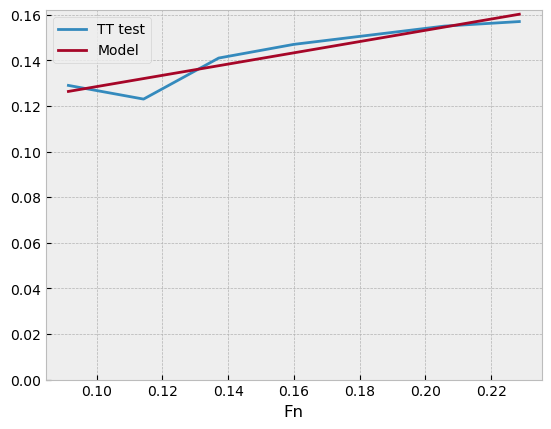

In [17]:
fig,ax=plt.subplots()
wTm.plot(ax=ax, label="TT test")
ax.plot(X.index, model_w0_fit.predict(X), label="Model")

ylim = ax.get_ylim()
ax.set_ylim(0,ylim[1])
ax.legend();

In [18]:
ηRm = df_resistance['ηRm'].copy()
g_=9.81
ηRm.index = df_resistance['VS']*1.852/3.6/np.sqrt(ship_data['L']*ship_data['scale_factor']*g_)
ηRm.index.name = 'Fn'

In [19]:
X = pd.DataFrame(index=ηRm.index)
X['Fn'] = ηRm.index
X['const'] = 1
model_ηRm = sm.OLS(ηRm,X)
model_ηRm_fit = model_ηRm.fit()

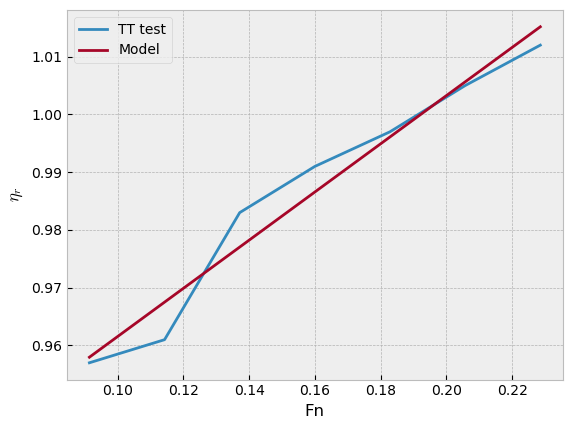

In [20]:
fig,ax=plt.subplots()
ηRm.plot(ax=ax, label="TT test")
ax.plot(X.index, model_ηRm_fit.predict(X), label="Model")

ax.set_ylabel(r'$\eta_r$')
ax.legend();

In [21]:
df_open_water = pd.read_csv("TT_open_water.csv", index_col=0)

In [22]:
eq_η0

Eq(eta_0, J*K_T/(2*pi*K_Q))

In [23]:
lambda_η0 = lambdify(eq_η0.rhs)
df_open_water['eta_0'] = run(lambda_η0, inputs=df_open_water, J=df_open_water.index)

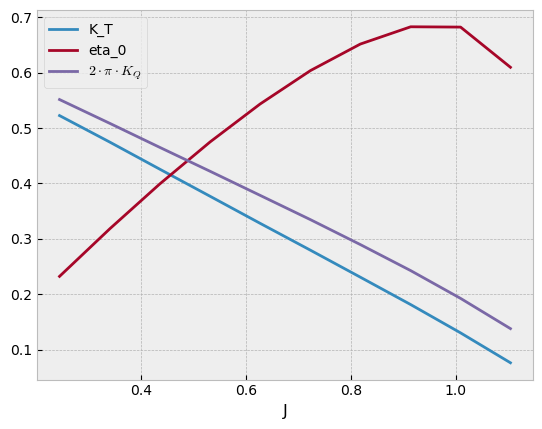

In [24]:
fig,ax=plt.subplots()
df_open_water.plot(y=['K_T','eta_0'], ax=ax)
ax.plot(df_open_water.index, 2*np.pi*df_open_water['K_Q'], label=r'$2 \cdot \pi \cdot K_Q$')
ax.legend()

In [25]:
def f(x,a,b,c):
    #return a+b*x**c
    return a + b*x + c*x**3
    
df_open_water['J'] = df_open_water.index
ydata = df_open_water['K_Q']/(df_open_water['K_T'])
popt, pcov = curve_fit(f=f, xdata=df_open_water['J'], ydata=ydata)

In [26]:
popt

array([ 0.18557406, -0.05575785,  0.11352627])

In [27]:
params_KQ = {f"C_KQ{i}":value for i,value in enumerate(popt)}
params_KQ

{'C_KQ0': 0.1855740619221727,
 'C_KQ1': -0.05575784891676352,
 'C_KQ2': 0.11352627320548968}

In [28]:
C_KQ0, C_KQ1, C_KQ2 = sp.symbols("C_KQ0, C_KQ1, C_KQ2")
eq_K_Q_K_T = sp.Eq(K_Q,K_T*(C_KQ0 + C_KQ1*J + C_KQ2*J**3))
eq_K_Q_K_T

Eq(K_Q, K_T*(C_KQ0 + C_KQ1*J + C_KQ2*J**3))

In [29]:
lambda_K_Q_K_T = lambdify(eq_K_Q_K_T.rhs)
lambda_K_Q_K_T

<function _lambdifygenerated(C_KQ0, C_KQ1, C_KQ2, J, K_T)>

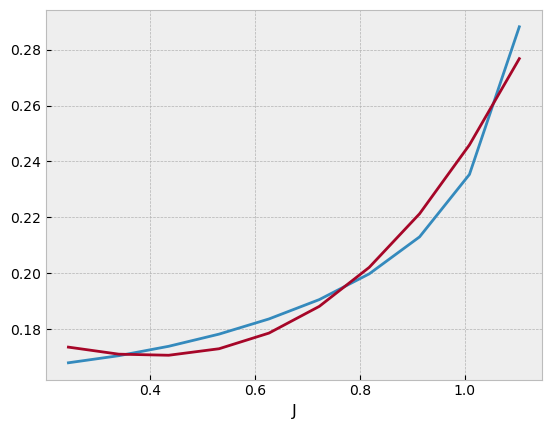

In [30]:
fig,ax=plt.subplots()
(df_open_water['K_Q']/(df_open_water['K_T'])).plot(ax=ax)
ypred = f(df_open_water['J'].values,*popt)
ax.plot(df_open_water['J'], ypred)

In [31]:
eq_to_matrix_K_Q = DiffEqToMatrix(eq_K_Q, label=K_Q, base_features=[J])
lambda_K_Q = lambdify(eq_K_Q.rhs)
X,y = eq_to_matrix_K_Q.calculate_features_and_label(data=df_open_water, y=df_open_water['K_Q'])
model_K_Q = sm.OLS(y,X)
model_K_Q_fit = model_K_Q.fit()

In [32]:
dict(model_K_Q_fit.params)

{'kq0': 0.10712327968482076, 'kq1': -0.07566495730452033}

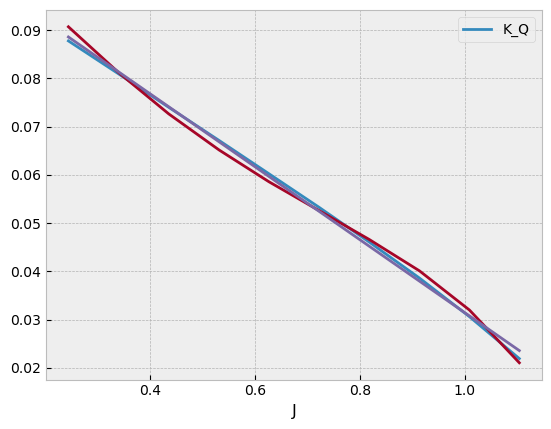

In [33]:
fig,ax=plt.subplots()
df_open_water.plot(y='K_Q', ax=ax)
#K_Q_pred = f(df_open_water['J'].values,*popt)*df_open_water['K_T']
K_Q_pred = run(lambda_K_Q_K_T,inputs=df_open_water, **params_KQ)
K_Q_pred2 = run(lambda_K_Q,inputs=df_open_water, k_q0=model_K_Q_fit.params['kq0'], k_q1=model_K_Q_fit.params['kq1'],)

ax.plot(df_open_water.index, K_Q_pred)
ax.plot(df_open_water.index, K_Q_pred2)
ax.legend()

## MDL

In [34]:
time_series_meta_data.head()

,project_number,series_number,run_number,test_number,model_number,ship_name,loading_condition_id,ascii_name,ship_speed,comment,file_path_ascii,file_path_ascii_temp,file_path_log,file_path_hdf5,date,test type,facility,angle1,angle2,scale_factor,name,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,CFP,AIX,PDTDES,RTYPE,SFP,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,AI,HSKEG,RSKEG,LOA,ship_type_id,xm,ym,zm,description
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
22639,40199079,1,4,12,M5139-02-A,M5139-02-A,167,NaN,0.641180,8.0 kn,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\0...,2020-10-02,reference speed,MDL,NaN,NaN,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,Reference speed 0.6 m/s
22638,40199079,1,3,12,M5139-02-A,M5139-02-A,167,NaN,0.641180,8.0 kn,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\0...,2020-10-02,reference speed,MDL,NaN,NaN,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,Reference speed 0.6 m/s
22637,40199079,1,2,12,M5139-02-A,M5139-02-A,167,NaN,0.641180,8.0 kn,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\0...,2020-10-02,reference speed,MDL,NaN,NaN,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,Reference speed 0.6 m/s
22636,40199079,1,1,12,M5139-02-A,M5139-02-A,167,NaN,0.641180,8.0 kn,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\0...,2020-10-02,reference speed,MDL,NaN,NaN,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,Reference speed 0.6 m/s
22634,40199079,1,4,10,M5139-02-A,M5139-02-A,167,NaN,0.801475,10.0 kn,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\0...,2020-10-06,reference speed,MDL,NaN,NaN,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,Reference speed 0.8 m/s


In [35]:
time_series_meta_data['test type'].unique()

array(['reference speed', 'sailing', 'turning circle', 'rodergrundvinkel',
       'zigzag'], dtype=object)

In [36]:
mask = time_series_meta_data['test type'].isin(['reference speed'])
meta_data_reference_speeds = time_series_meta_data.loc[mask]
meta_data_reference_speeds

,project_number,series_number,run_number,test_number,model_number,ship_name,loading_condition_id,ascii_name,ship_speed,comment,file_path_ascii,file_path_ascii_temp,file_path_log,file_path_hdf5,date,test type,facility,angle1,angle2,scale_factor,name,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,CFP,AIX,PDTDES,RTYPE,SFP,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,AI,HSKEG,RSKEG,LOA,ship_type_id,xm,ym,zm,description
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
22639,40199079,1,4,12,M5139-02-A,M5139-02-A,167,NaN,0.641180,8.0 kn,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\0...,2020-10-02,reference speed,MDL,NaN,NaN,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,Reference speed 0.6 m/s
22638,40199079,1,3,12,M5139-02-A,M5139-02-A,167,NaN,0.641180,8.0 kn,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\0...,2020-10-02,reference speed,MDL,NaN,NaN,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,Reference speed 0.6 m/s
22637,40199079,1,2,12,M5139-02-A,M5139-02-A,167,NaN,0.641180,8.0 kn,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\0...,2020-10-02,reference speed,MDL,NaN,NaN,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,Reference speed 0.6 m/s
22636,40199079,1,1,12,M5139-02-A,M5139-02-A,167,NaN,0.641180,8.0 kn,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\0...,2020-10-02,reference speed,MDL,NaN,NaN,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,Reference speed 0.6 m/s
22634,40199079,1,4,10,M5139-02-A,M5139-02-A,167,NaN,0.801475,10.0 kn,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\0...,2020-10-06,reference speed,MDL,NaN,NaN,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,Reference speed 0.8 m/s
22635,40199079,1,5,10,M5139-02-A,M5139-02-A,167,NaN,0.801475,10.0 kn,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\0...,2020-10-06,reference speed,MDL,NaN,NaN,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,Reference speed 0.8 m/s
22633,40199079,1,3,10,M5139-02-A,M5139-02-A,167,NaN,0.801475,10.0 kn,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\0...,2020-10-06,reference speed,MDL,NaN,NaN,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,Reference speed 0.8 m/s
22632,40199079,1,2,10,M5139-02-A,M5139-02-A,167,NaN,0.801475,10.0 kn,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\0...,2020-10-05,reference speed,M

In [37]:
_n_prop = 2
_ = []
for id, row in meta_data_reference_speeds.iterrows():
    loader = time_series[id]
    df_ = loader()
    #df_ = load(df_).rolling(100).mean().dropna()
    df_ = load(df_).rolling(1000).mean().dropna()
    df_ = add_thrust(df_, thrust_channels=['Prop/SB/Thrust', 'Prop/PS/Thrust'])
    df_['torque'] = df_['Prop/SB/Torque'].abs() + df_['Prop/PS/Torque'].abs()
    df_['thrust_propeller'] = df_['thrust']/_n_prop
    df_['torque_propeller'] = df_['torque']/_n_prop
        
    df_['rev'] = df_[['Prop/SB/Rpm', 'Prop/PS/Rpm']].mean(axis=1)
    df_['id'] = id
    _.append(df_)
data_all = pd.concat(_)  

<Axes: title={'center': 'Track plot'}, xlabel='$y_0$ $[m]$', ylabel='$x_0$ $[m]$'>

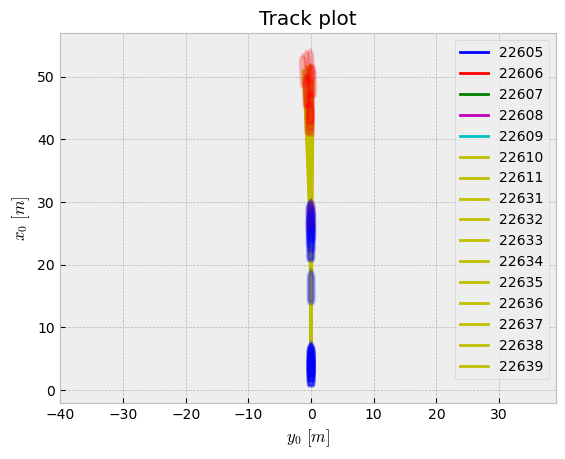

In [38]:
dataframes = {id:group for id, group in data_all.groupby(by='id')}
track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=3)

In [39]:
eq_Q

Eq(torque_propeller, D**5*K_Q*rev**2*rho/eta_r)

In [40]:
lambda_KT = lambdify(sp.solve(eq_T,K_T)[0])
lambda_KQ = lambdify(sp.solve(eq_Q,K_Q)[0])
lambda_J = lambdify(sp.solve(eq_J,J)[0])

In [41]:
data_all['Fn'] = data_all['u']/np.sqrt(ship_data['L']*g_)
X_ = data_all[['Fn']].copy()
X_['const'] = 1
data_all['w_p'] = model_w0_fit.predict(X_)
data_all['eta_r'] = model_ηRm_fit.predict(X_)
data_all['K_T'] = run(lambda_KT, inputs=data_all, **ship_data)
data_all['K_Q'] = run(lambda_KQ, inputs=data_all, **ship_data)
data_all['J'] = run(lambda_J, inputs=data_all, **ship_data)

<Axes: >

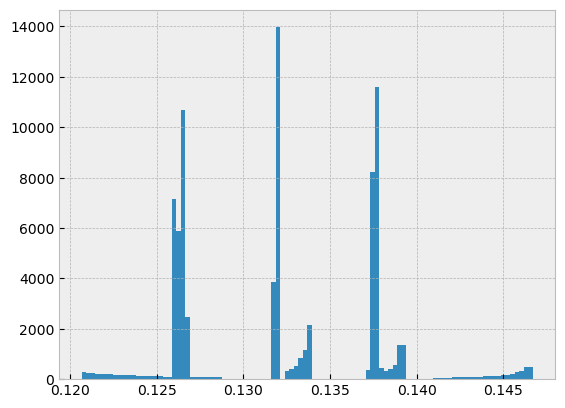

In [42]:
data_all['w_p'].hist(bins=100)

<Axes: >

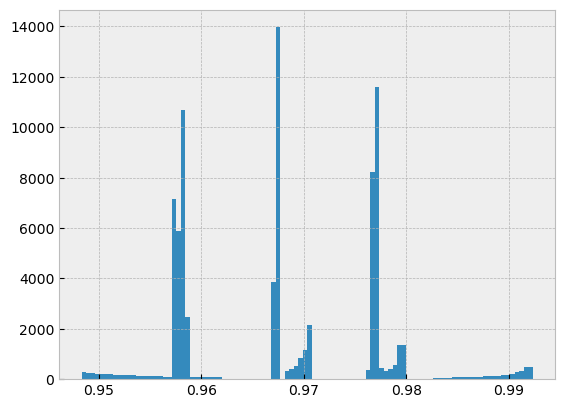

In [43]:
data_all['eta_r'].hist(bins=100)

In [44]:
mask = data_all['J'] < 0.65
data_all.loc[mask].groupby('id').count()['J']

id
22606    422
Name: J, dtype: int64

In [45]:
eq_K_T

Eq(K_T, J**2*k_2 + J*k_1 + k_0)

In [46]:
eq_to_matrix = DiffEqToMatrix(ode=eq_K_T, label=K_T, base_features=[J])
mask = ((data_all['J'] < 0.7) | (data_all['J'] > 0.8))
data_ = data_all.loc[mask]
X,y = eq_to_matrix.calculate_features_and_label(data=data_, y=data_['K_T'])
model = sm.OLS(y,X)
model_fit = model.fit()

In [47]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    K_T   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 7.560e+06
Date:                Wed, 07 Jun 2023   Prob (F-statistic):               0.00
Time:                        08:55:21   Log-Likelihood:                 64115.
No. Observations:               13368   AIC:                        -1.282e+05
Df Residuals:                   13365   BIC:                        -1.282e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
k0             0.5766      0.001    747.016      0.000       0.575       0.578
k1            -0.3684      0.002   -200.555      0.000      -0.372      -0.365
k2            -0.0754      0.001    -71.335      0.000      -0.078      -0.073
==============================================================================
Omnibus:                      938.805   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1185.474
Skew:                           0.657   Prob(JB):                    3.78e-258
Kurtosis:                       3.636   Cond. No.                         185.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

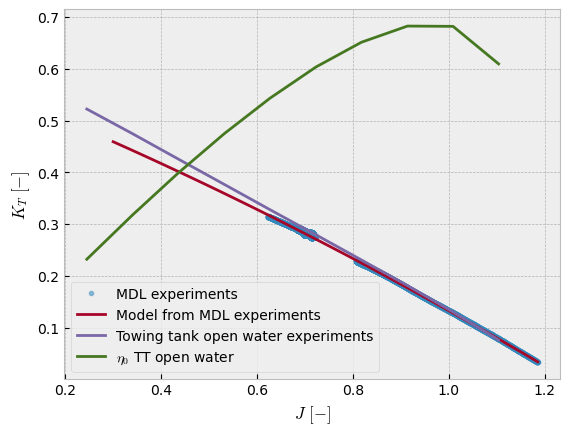

In [134]:
fig,ax=plt.subplots()
data_all.plot(x='J', y='K_T', style='.', alpha=0.50, ax=ax, label='MDL experiments')
df_predict = pd.DataFrame()
df_predict['J'] = np.linspace(0.3, data_all['J'].max(), 100)
X_ = eq_to_matrix.calculate_features(data=df_predict)
df_predict['K_T'] = model_fit.predict(X_)
df_predict.plot(x='J', y='K_T', ax=ax, label='Model from MDL experiments')

df_open_water.plot(y='K_T', label='Towing tank open water experiments', ax=ax)
df_open_water.plot(y='eta_0', label=r'$\eta_0$ TT open water', ax=ax)

ax.legend()
ax.set_xlabel('$J$ $[-]$');
ax.set_ylabel('$K_T$ $[-]$');
fig.savefig("summaries/K_T.png")

In [49]:
eq_K_Q

Eq(K_Q, J*k_q1 + k_q0)

In [50]:
eq_to_matrix_Kq = DiffEqToMatrix(ode=eq_K_Q, label=K_Q, base_features=[J])
mask = ((data_all['J'] > 0.8) & (data_all['J'] < 1.1))
data_ = data_all.loc[mask]
X,y = eq_to_matrix_Kq.calculate_features_and_label(data=data_, y=data_['K_Q'])
model_Kq = sm.OLS(y,X)
model_Kq_fit = model_Kq.fit()

In [51]:
model_Kq_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    K_Q   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 4.527e+05
Date:                Wed, 07 Jun 2023   Prob (F-statistic):               0.00
Time:                        08:55:22   Log-Likelihood:                 22967.
No. Observations:                3686   AIC:                        -4.593e+04
Df Residuals:                    3684   BIC:                        -4.592e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
kq0            0.0730    8.9e-05    821.065      0.000       0.073       0.073
kq1           -0.0645   9.59e-05   -672.838      0.000      -0.065      -0.064
==============================================================================
Omnibus:                     1409.530   Durbin-Watson:                   0.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7534.633
Skew:                           1.750   Prob(JB):                         0.00
Kurtosis:                       9.067   Cond. No.                         22.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
sp.simplify((eq_T.rhs*u/(eq_Q.rhs*2*sp.pi*rev)).subs(rev,sp.solve(eq_J,rev)[0]).subs(w_p,0))

J*K_T*eta_r/(2*pi*K_Q)

In [53]:
sp.solve(eq_J,rev)[0]

u*(1 - w_p)/(D*J)

In [54]:
eq_η0

Eq(eta_0, J*K_T/(2*pi*K_Q))

In [55]:
sp.Eq(K_Q,sp.solve(eq_η0, K_Q)[0])

Eq(K_Q, J*K_T/(2*pi*eta_0))

In [56]:
lambda_KQ_η0 = lambdify(sp.solve(eq_η0, K_Q)[0])
lambda_KQ_η0

<function _lambdifygenerated(J, K_T, eta_0)>

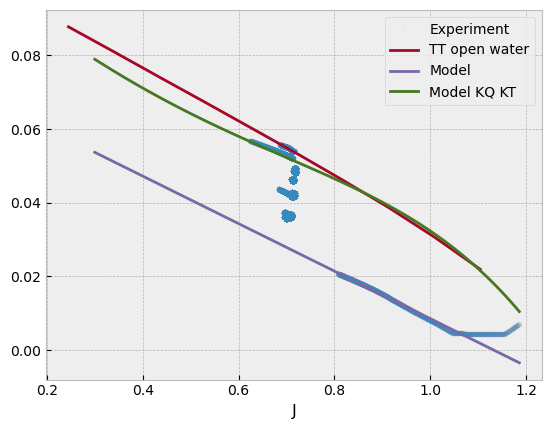

In [57]:
fig,ax=plt.subplots()
data_all.plot(x='J', y='K_Q', style='.', alpha=0.01, ax=ax, label='Experiment')
df_predict = pd.DataFrame()
df_predict['J'] = np.linspace(0.3, data_all['J'].max(), 100)
X_ = eq_to_matrix_Kq.calculate_features(data=df_predict)
df_predict['K_Q'] = model_Kq_fit.predict(X_)

df_open_water.plot(y='K_Q', label='TT open water', ax=ax)

X_ = eq_to_matrix.calculate_features(data=df_predict)
df_predict['K_T'] = model_fit.predict(X_)
df_predict['K_Q_2'] = f(df_predict['J'].values,*popt)*df_predict['K_T']


df_predict.plot(x='J', y='K_Q', ax=ax, label='Model')
df_predict.plot(x='J', y='K_Q_2', ax=ax, label='Model KQ KT')
#df_predict.plot(x='J', y='K_Q_eta0', ax=ax, label='Model eta0')
ax.legend()

## Oblique inflow

In [58]:
_ = []
for id, loader in time_series_smooth.items():
    if id == 'wpcc.updated.joined.ek_smooth':
        continue
        
    if id == 'wpcc.updated.22774.ek_smooth':  # Something wrong with the turning circle (rev is not the same for port and stbd)
        continue
            
    df_ = loader()
    df_['rev'] = df_[['Prop/SB/Rpm', 'Prop/PS/Rpm']].mean(axis=1)
    df_['id'] = id
    _.append(df_)
data_all_smooth = pd.concat(_)
data_all_smooth['V'] = np.sqrt(data_all_smooth['u']**2 + data_all_smooth['v']**2)
data_all_smooth['U'] = data_all_smooth['V']

In [59]:
data_all_smooth.head()

,x0,y0,psi,u,v,r,Prop/PS/Torque,roll,v1d,z0,Prop/SB/Rpm,Prop/PS/Thrust,thrust,Prop/PS/Rpm,U,V,u1d,r1d,Prop/SB/Thrust,Prop/SB/Torque,delta,pitch,rev,id,Fan/Fore/CalcAngle,Wind/Course,Wind/CourseTreshold,Wind/Enable,Fan/Aft/CalcAngle
0.00,0.009086,-0.002225,-0.000529,0.955115,0.003604,0.001300,-0.127033,0.000368,-0.001772,0.000000,9.573445,5.489899,10.714020,9.634599,0.955122,0.955122,0.001422,-0.000933,5.224121,0.105243,-0.002288,0.000183,9.604022,wpcc.updated.22611.ek_smooth,NaN,NaN,NaN,NaN,NaN
0.01,0.018637,-0.002195,-0.000516,0.955130,0.003586,0.001291,-0.124941,0.000315,-0.001770,-0.000035,9.550259,5.586038,10.910968,9.588592,0.955136,0.955136,0.001649,-0.000929,5.324930,0.107902,-0.002308,0.000040,9.569425,wpcc.updated.22611.ek_smooth,NaN,NaN,NaN,NaN,NaN
0.02,0.028188,-0.002165,-0.000503,0.955148,0.003568,0.001281,-0.121120,0.000276,-0.001764,0.000004,9.578746,5.657048,11.083733,9.586937,0.955155,0.955155,0.002077,-0.000922,5.426686,0.109366,-0.002295,0.000200,9.582841,wpcc.updated.22611.ek_smooth,NaN,NaN,NaN,NaN,NaN
0.03,0.037739,-0.002135,-0.000490,0.955171,0.003551,0.001272,-0.116768,0.000321,-0.001758,-0.000044,9.580600,5.663043,11.156748,9.517574,0.955178,0.955178,0.002360,-0.000916,5.493705,0.109235,-0.002302,0.000003,9.549087,wpcc.updated.22611.ek_smooth,NaN,NaN,NaN,NaN,NaN
0.04,0.047291,-0.002106,-0.000478,0.955196,0.003533,0.001263,-0.113437,0.000265,-0.001752,0.000005,9.554822,5.591220,11.107342,9.506373,0.955202,0.955202,0.002384,-0.000911,5.516122,0.107665,-0.002288,0.000203,9.530597,wpcc.updated.22611.ek_smooth,NaN,NaN,NaN,NaN,NaN


In [60]:
lambda_thrust = lambdify(sp.solve(eq_T, thrust_propeller)[0])

In [61]:
#data_all_smooth['K_T'] = run(lambda_KT, inputs=data_all_smooth, **ship_data)

# u
data_all_smooth['Fn'] = data_all_smooth['u']/np.sqrt(ship_data['L']*g_)
X_ = data_all_smooth[['Fn']].copy()
X_['const'] = 1
data_all_smooth['w_p'] = model_w0_fit.predict(X_)

data_all_smooth['J'] = run(lambda_J, inputs=data_all_smooth, **ship_data)
X_ = eq_to_matrix.calculate_features(data=data_all_smooth)
data_all_smooth['K_T'] = model_fit.predict(X_)
data_all_smooth['thrust_predict_u'] = run(function=lambda_thrust, inputs=data_all_smooth, **ship_data)

# V
data_all_smooth['Fn'] = data_all_smooth['V']/np.sqrt(ship_data['L']*g_)
X_ = data_all_smooth[['Fn']].copy()
X_['const'] = 1
data_all_smooth['w_p'] = model_w0_fit.predict(X_)

data_all_smooth['J'] = lambda_J(D=ship_data['D'], rev=data_all_smooth['rev'], u=data_all_smooth['V'], w_p=data_all_smooth['w_p'])
X_ = eq_to_matrix.calculate_features(data=data_all_smooth)
data_all_smooth['K_T'] = model_fit.predict(X_)
data_all_smooth['thrust_predict_V'] = run(function=lambda_thrust, inputs=data_all_smooth, **ship_data)

<Axes: xlabel='thrust'>

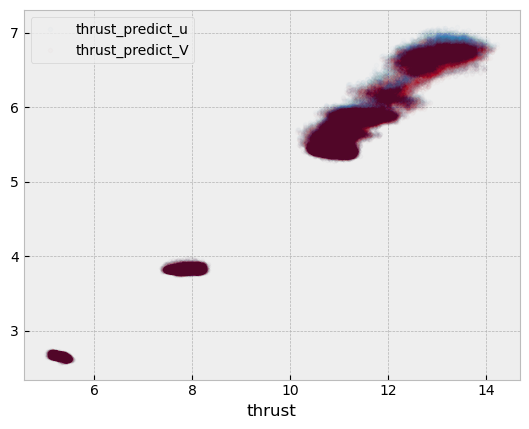

In [62]:
data_all_smooth.plot(x='thrust', y =['thrust_predict_u','thrust_predict_V'], style='.', alpha=0.01)

<Axes: >

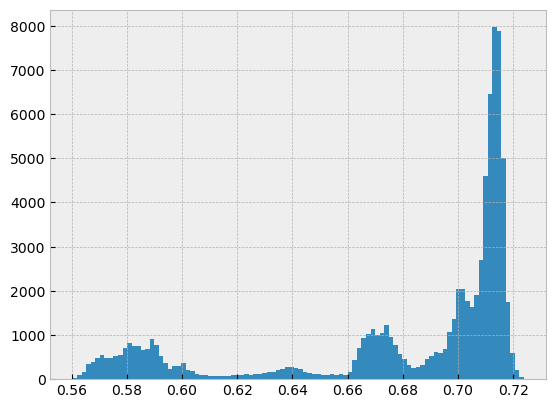

In [63]:
data_all_smooth['J'].hist(bins=100)

In [64]:
r2_score(y_true = data_all_smooth['thrust'], y_pred=data_all_smooth['thrust_predict_u'])

-5.402931992521292

In [65]:
r2_score(y_true = data_all_smooth['thrust'], y_pred=data_all_smooth['thrust_predict_V'])

-5.45313976586093

In [66]:
_ = []
for id, loader in time_series_smooth.items():
    
    if id == 'wpcc.updated.joined.ek_smooth':
        continue
    
    if id == 'wpcc.updated.22774.ek_smooth':  # Something wrong with the turning circle (rev is not the same for port and stbd)
        continue
    
        
    df_ = loader()
    df_['rev'] = df_[['Prop/SB/Rpm', 'Prop/PS/Rpm']].mean(axis=1)
    df_['thrust_propeller'] = df_['thrust']/_n_prop
    #df_['torque_propeller'] = df_['torque']/_n_prop
    df_ = df_.rolling(10).mean().dropna()
    df_['id'] = id
    
    _.append(df_)
data_all_smooth = pd.concat(_)
data_all_smooth['V'] = data_all_smooth['U'] = np.sqrt(data_all_smooth['u']**2 + data_all_smooth['v']**2)
data_all_smooth['beta'] = -np.arctan2(data_all_smooth['v'], data_all_smooth['u'])

quantile_min = 0.6
mask = ((data_all_smooth['beta'].abs() > data_all_smooth['beta'].abs().quantile(quantile_min)) | 
        (data_all_smooth['r'].abs() > data_all_smooth['r'].abs().quantile(quantile_min))
       )
data_all_smooth=data_all_smooth.loc[mask].copy()

<Axes: >

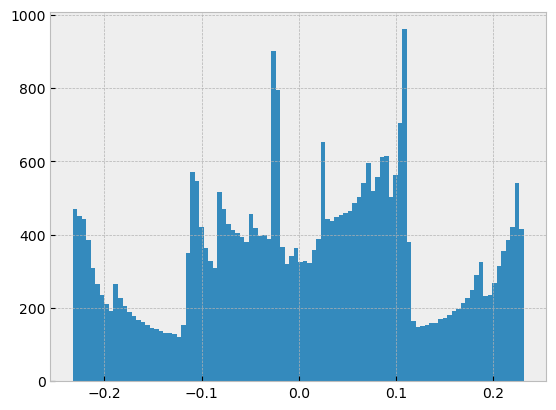

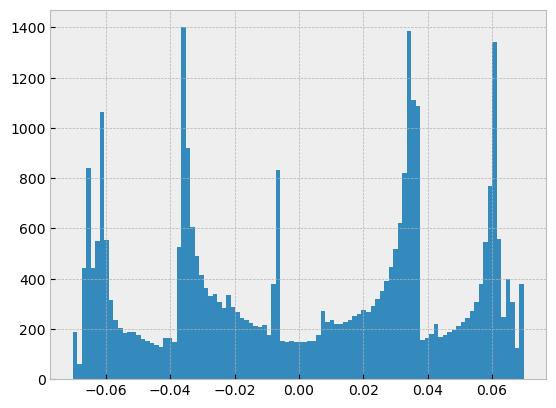

In [67]:
fig,ax=plt.subplots()
data_all_smooth['beta'].hist(bins=100, ax=ax)
fig,ax=plt.subplots()
data_all_smooth['r'].hist(bins=100, ax=ax)

<Axes: >

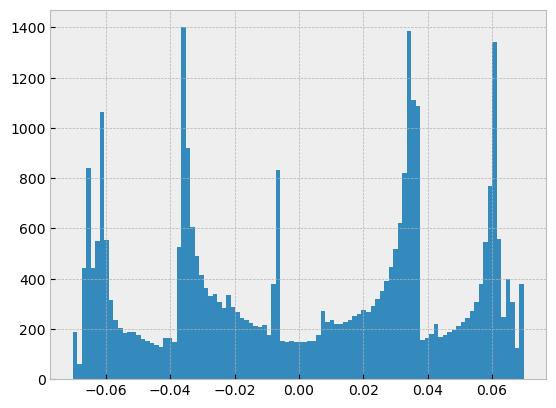

In [68]:
data_all_smooth['r'].hist(bins=100)

In [69]:
data_all_smooth['Fn'] = data_all_smooth['u']/np.sqrt(ship_data['L']*g_)
X_ = data_all_smooth[['Fn']].copy()
X_['const'] = 1
data_all_smooth['w_p0'] = model_w0_fit.predict(X_)
data_all_smooth['K_T'] = run(lambda_KT, inputs=data_all_smooth, **ship_data)

In [70]:
eq_T

Eq(thrust_propeller, D**4*K_T*rev**2*rho)

In [71]:
eq_K_T

Eq(K_T, J**2*k_2 + J*k_1 + k_0)

In [72]:
eq_J2 = eq_J.subs(u,U)
eq_J2

Eq(J, U*(1 - w_p)/(D*rev))

In [73]:
eqs = [eq_K_T,eq_J]
solutions = sp.solve(eqs, w_p,J, dict=True)

In [74]:
eq_w_p = sp.Eq(w_p,solutions[0][w_p])
eq_w_p

Eq(w_p, (-D*rev*(-k_1/(2*k_2) - sqrt(4*K_T*k_2 - 4*k_0*k_2 + k_1**2)/(2*k_2)) + u)/u)

In [75]:
eq_thrust_simple

Eq(thrust_propeller, D**2*rho*(D**2*k_0*rev**2 - D*k_1*rev*u*w_p + D*k_1*rev*u + k_2*u**2*w_p**2 - 2*k_2*u**2*w_p + k_2*u**2))

In [76]:
eqs = [eq_T,eq_K_T, eq_J]
solution = sp.solve(eqs,thrust_propeller, K_T, J,dict=True)[0][thrust_propeller]
eq_thrust_simple = sp.Eq(thrust_propeller, solution)
solution = sp.solve(eq_thrust_simple, w_p, dict=True)[1][w_p]
eq_w_p = sp.Eq(w_p, solution)

In [77]:
eq_w_p

Eq(w_p, (D*rho*(D*k_1*rev + 2*k_2*u) + sqrt(rho*(-4*D**4*k_0*k_2*rev**2*rho + D**4*k_1**2*rev**2*rho + 4*k_2*thrust_propeller)))/(2*D*k_2*rho*u))

In [78]:
lambda_w_p = lambdify(eq_w_p.rhs)

In [79]:
lambda_w_p

<function _lambdifygenerated(D, k_0, k_1, k_2, rev, rho, thrust_propeller, u)>

In [80]:
data_all_smooth['w_p'] = run(function=lambda_w_p, inputs=data_all_smooth, **ship_data, k_0=model_fit.params['k0'], k_1=model_fit.params['k1'], k_2=model_fit.params['k2'])

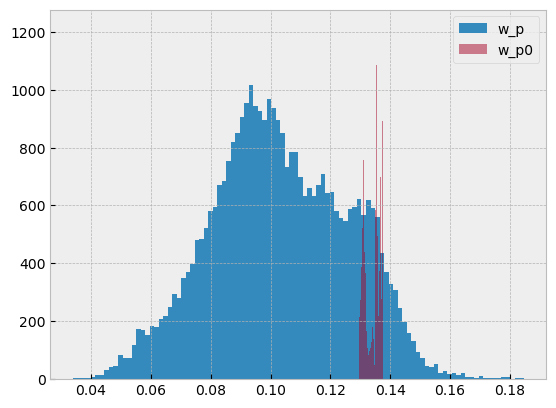

In [81]:
fig,ax=plt.subplots()
data_all_smooth['w_p'].hist(bins=100, label='w_p',ax=ax)
data_all_smooth['w_p0'].hist(bins=100, label='w_p0', ax=ax, alpha=0.5)
ax.legend()


In [82]:
mask = data_all_smooth['w_p'] < 0
data_all_smooth.loc[mask].groupby(by='id').count()['w_p']

Series([], Name: w_p, dtype: int64)

In [83]:
eq_beta_p

Eq(beta_p, beta - r*x_r/U)

In [84]:
lambda_beta_p = lambdify(eq_beta_p.rhs)

In [85]:
data_all_smooth['beta_p'] = run(function=lambda_beta_p, inputs=data_all_smooth, **ship_data)

Text(0, 0.5, '$\\beta_p$ $[deg]$')

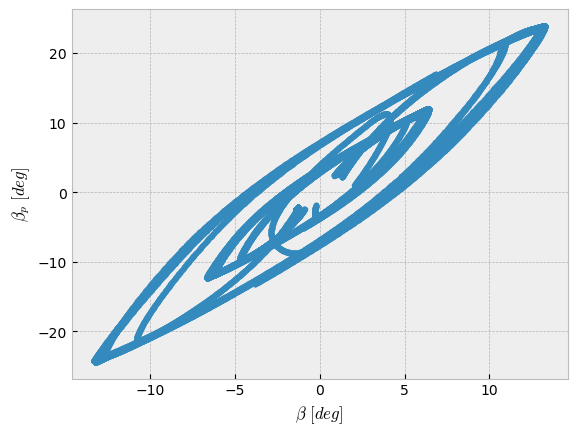

In [86]:
fig,ax=plt.subplots()
ax.plot(np.rad2deg(data_all_smooth['beta']), np.rad2deg(data_all_smooth['beta_p']), '.')
ax.set_xlabel(r'$\beta$ $[deg]$')
ax.set_ylabel(r'$\beta_p$ $[deg]$')


In [87]:
C_3,C_4 = sp.symbols("C_3 C_4")
eq_model_wp = sp.Eq(w_p, w_p0 + C_1*delta+C_2*delta**2 + C_3*beta_p**2 + C_4*u)
eq_model_wp


Eq(w_p, C_1*delta + C_2*delta**2 + C_3*beta_p**2 + C_4*u + w_p0)

In [88]:
eq = sp.Eq(eq_model_wp.lhs-w_p0, eq_model_wp.rhs-w_p0)
eq

Eq(w_p - w_p0, C_1*delta + C_2*delta**2 + C_3*beta_p**2 + C_4*u)

In [89]:
model_wp_to_matrix = DiffEqToMatrix(ode=eq, label=w_p-w_p0, base_features=[delta, beta_p, u])

In [90]:
data_all_smooth['w_p_diff'] = data_all_smooth['w_p'] - data_all_smooth['w_p0']

<Axes: xlabel='beta_p'>

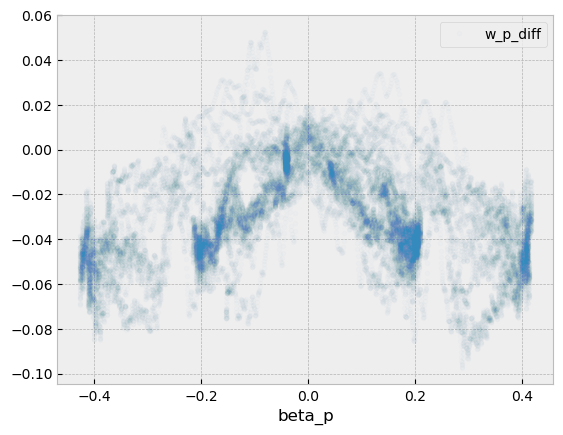

In [91]:
data_all_smooth.plot(x='beta_p', y= 'w_p_diff', style='.', alpha=0.01)

<Axes: xlabel='delta'>

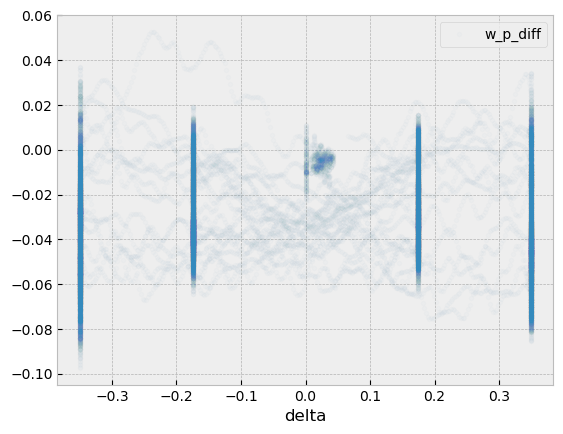

In [92]:
data_all_smooth.plot(x='delta', y= 'w_p_diff', style='.', alpha=0.01)

In [93]:
X = model_wp_to_matrix.calculate_features(data=data_all_smooth)
y = (data_all_smooth['w_p'] - data_all_smooth['w_p0'])
model_wp = sm.OLS(y,X)

In [94]:
X

,C1,C2,C3,C4
0.740000,0.076630,0.005872,0.002152,0.943988
0.750000,0.074113,0.005493,0.002162,0.944035
0.760000,0.071456,0.005106,0.002172,0.944083
0.770000,0.068484,0.004690,0.002180,0.944130
0.780000,0.065778,0.004327,0.002188,0.944177
...,...,...,...,...
69.780004,0.349071,0.121851,0.052289,0.782967
69.790004,0.349071,0.121851,0.052452,0.783023
69.800004,0.349072,0.121851,0.052616,0.783079
69.810004,0.349070,0.121850,0.052780,0.783135


In [95]:
model_wp_fit = model_wp.fit()

In [96]:
model_wp_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.759
Model:                            OLS   Adj. R-squared (uncentered):              0.759
Method:                 Least Squares   F-statistic:                          2.802e+04
Date:                Wed, 07 Jun 2023   Prob (F-statistic):                        0.00
Time:                        08:55:36   Log-Likelihood:                          91483.
No. Observations:               35567   AIC:                                 -1.830e+05
Df Residuals:                   35563   BIC:                                 -1.829e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
C1             0.0014      0.000      3.810      0.000       0.001       0.002
C2            -0.0062      0.002     -2.725      0.006      -0.011      -0.002
C3            -0.2201      0.002   -112.897      0.000      -0.224      -0.216
C4            -0.0204      0.000   -107.645      0.000      -0.021      -0.020
==============================================================================
Omnibus:                       34.083   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.786
Skew:                          -0.068   Prob(JB):                     4.61e-08
Kurtosis:                       2.934   Cond. No.                         23.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
r2_score(y+data_all_smooth['w_p0'], model_wp_fit.predict(X)+data_all_smooth['w_p0'])

0.3479337910121135

In [98]:
r2_score(data_all_smooth['w_p'], data_all_smooth['w_p0'])

-1.707050764362672

In [99]:
X = pd.DataFrame(index=data_all_smooth.index)
X['delta**2'] = data_all_smooth['delta']**2
#X['beta_p**2'] = data_all_smooth['beta_p'].abs()
X['r**2'] = data_all_smooth['r'].abs()
#X['beta**2'] = data_all_smooth['beta']**2
#X['u'] = data_all_smooth['u']

#X['const'] = 1
y = (data_all_smooth['w_p'] - data_all_smooth['w_p0'])
model_wp2 = sm.OLS(y,X)
model_wp2_fit = model_wp2.fit()

In [100]:
model_wp2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.831
Model:                            OLS   Adj. R-squared (uncentered):              0.831
Method:                 Least Squares   F-statistic:                          8.735e+04
Date:                Wed, 07 Jun 2023   Prob (F-statistic):                        0.00
Time:                        08:55:37   Log-Likelihood:                          97771.
No. Observations:               35567   AIC:                                 -1.955e+05
Df Residuals:                   35565   BIC:                                 -1.955e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
delta**2       0.1138      0.002     53.091      0.000       0.110       0.118
r**2          -1.0039      0.004   -234.448      0.000      -1.012      -0.996
==============================================================================
Omnibus:                      704.212   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1133.032
Skew:                           0.194   Prob(JB):                    9.23e-247
Kurtosis:                       3.783   Cond. No.                         5.35
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [101]:
r2_score(y+data_all_smooth['w_p0'], model_wp2_fit.predict(X)+data_all_smooth['w_p0'])

0.542140211227607

In [102]:
test = data_all_smooth.groupby(by='id').get_group('wpcc.updated.22773.ek_smooth').copy()

<Axes: title={'center': 'Track plot'}, xlabel='$y_0$ $[m]$', ylabel='$x_0$ $[m]$'>

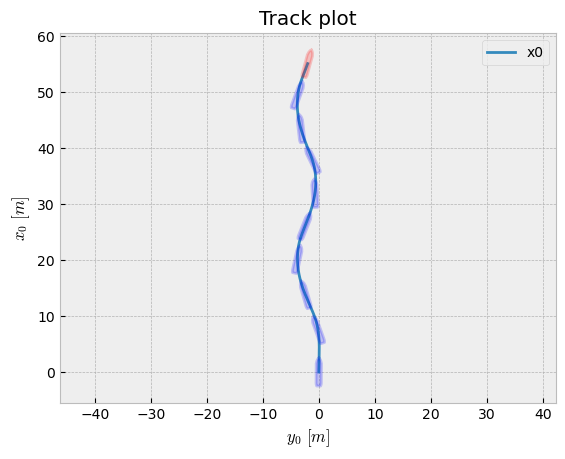

In [103]:
track_plot(test, lpp=ship_data['L'], beam=ship_data['B'], N=10)

It seems that there is a difference between the thrust from the port and starboard propeller 

<Axes: >

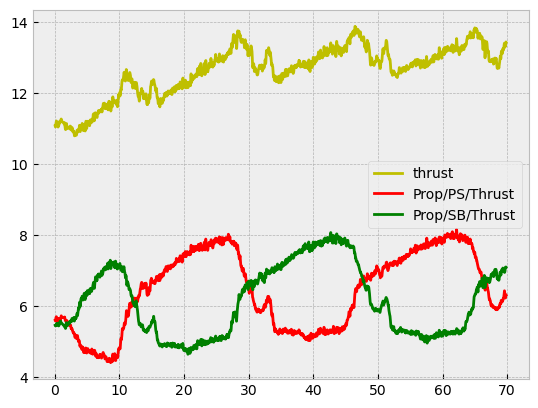

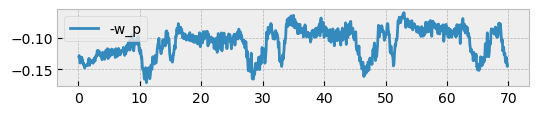

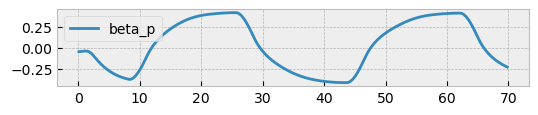

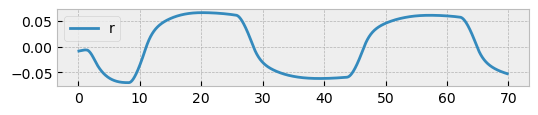

In [142]:
fig,ax=plt.subplots()
test.plot(y=['thrust','Prop/PS/Thrust','Prop/SB/Thrust'], style=['y-','r-','g-'], ax=ax)
fig.savefig("summaries/thrust_zigzag_port_stbd.png")

fig,ax=plt.subplots()
fig.set_size_inches(6.08,1)
test['-w_p'] = -test['w_p']
test.plot(y='-w_p', ax=ax)

fig,ax=plt.subplots()
fig.set_size_inches(6.08,1)
test.plot(y='beta_p', ax=ax)
fig,ax=plt.subplots()
fig.set_size_inches(6.08,1)
test.plot(y='r', ax=ax)

<Axes: >

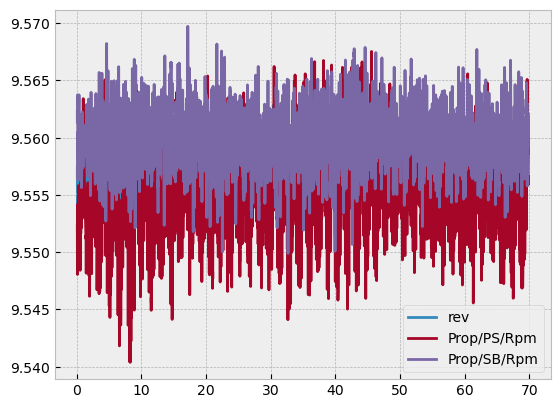

In [105]:
test.plot(y=['rev','Prop/PS/Rpm','Prop/SB/Rpm'])

In [106]:
test_predict_w0 = test.copy()
test_predict_w0['Fn'] = test_predict_w0['u']/np.sqrt(ship_data['L']*g_)

X_ = test_predict_w0[['Fn']].copy()
X_['const'] = 1
test_predict_w0['w_p'] = model_w0_fit.predict(X_)

test_predict_w0['J'] = lambda_J(D=ship_data['D'], rev=test_predict_w0['rev'], u=test_predict_w0['u'], w_p=test_predict_w0['w_p'])
X_ = eq_to_matrix.calculate_features(data=test_predict_w0)
test_predict_w0['K_T'] = model_fit.predict(X_)
test_predict_w0['thrust'] = 2*run(function=lambda_thrust, inputs=test_predict_w0, **ship_data)

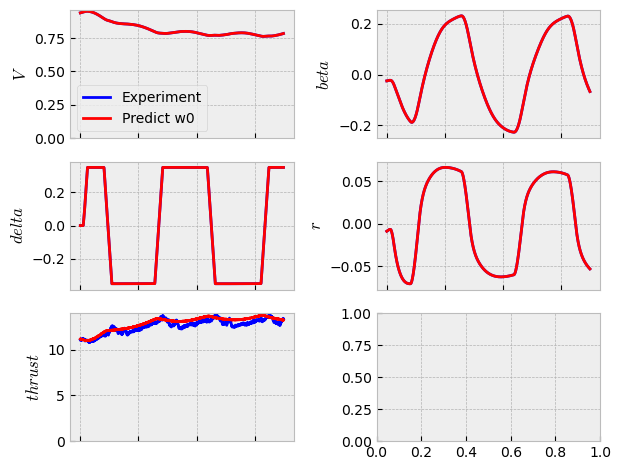

In [107]:
dataframes={'Experiment':test,
           'Predict w0': test_predict_w0,
           }
plot(dataframes=dataframes, keys=['thrust','V','beta','r','delta']);

In [108]:
test_predict_w0 = test.copy()
test_predict_w0['Fn'] = test_predict_w0['V']/np.sqrt(ship_data['L']*g_)

X_ = test_predict_w0[['Fn']].copy()
X_['const'] = 1
test_predict_w0['w_p'] = model_w0_fit.predict(X_)

test_predict_w0['J'] = lambda_J(D=ship_data['D'], rev=test_predict_w0['rev'], u=test_predict_w0['V'], w_p=test_predict_w0['w_p'])
X_ = eq_to_matrix.calculate_features(data=test_predict_w0)
test_predict_w0['K_T'] = model_fit.predict(X_)
test_predict_w0['thrust'] = 2*run(function=lambda_thrust, inputs=test_predict_w0, **ship_data)

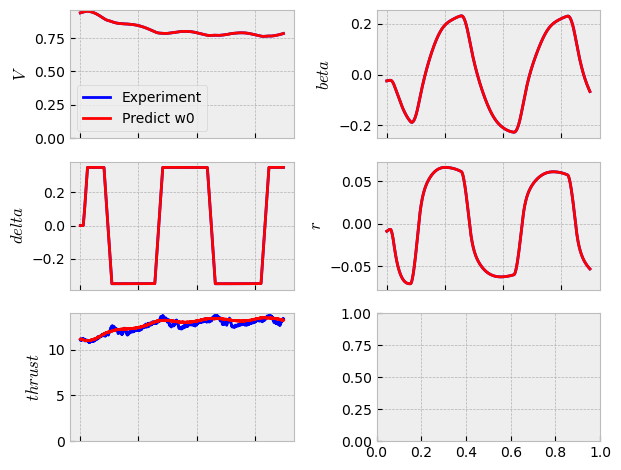

In [109]:
dataframes={'Experiment':test,
           'Predict w0': test_predict_w0,
           }
plot(dataframes=dataframes, keys=['thrust','V','beta','r','delta']);

In [110]:
model_w0_fit.params

Fn       0.246905
const    0.103786
dtype: float64

In [111]:
C0_w_p0,C1_w_p0,F_n = sp.symbols("C0_w_p0, C1_w_p0,F_n")
eq_w_p0 = sp.Eq(w_p0, C0_w_p0 + C1_w_p0*F_n)
eq_w_p0

Eq(w_p0, C0_w_p0 + C1_w_p0*F_n)

In [112]:
eq_F_n = sp.Eq(F_n,U/sp.sqrt(L*g))
eq_F_n

Eq(F_n, U/sqrt(L*g))

In [113]:
eq_w_p0 = eq_w_p0.subs(F_n, eq_F_n.rhs)
eq_w_p0

Eq(w_p0, C0_w_p0 + C1_w_p0*U/sqrt(L*g))

Assuming that $w_{p0}$ is a good model:

In [114]:
eq_w_p = eq_w_p0.subs(w_p0,w_p)
eq_w_p

Eq(w_p, C0_w_p0 + C1_w_p0*U/sqrt(L*g))

In [115]:
model_fit.params

k0    0.576582
k1   -0.368368
k2   -0.075430
dtype: float64

In [116]:
eq_to_matrix.acceleration_equation

Eq(K_T, J**2*k_2 + J*k_1 + k_0)

In [117]:
eqs = [eq_T,eq_K_T, eq_J, eq_w_p]
solution = sp.solve(eqs, thrust_propeller, K_T, J, w_p, dict=True)

In [118]:
eq = sp.Eq(thrust,n_prop*solution[0][thrust_propeller])
eq

Eq(thrust, D**2*n_prop*rho*(C0_w_p0**2*L*g*k_2*u**2 + 2*C0_w_p0*C1_w_p0*U*k_2*u**2*sqrt(L*g) - C0_w_p0*D*L*g*k_1*rev*u - 2*C0_w_p0*L*g*k_2*u**2 + C1_w_p0**2*U**2*k_2*u**2 - C1_w_p0*D*U*k_1*rev*u*sqrt(L*g) - 2*C1_w_p0*U*k_2*u**2*sqrt(L*g) + D**2*L*g*k_0*rev**2 + D*L*g*k_1*rev*u + L*g*k_2*u**2)/(L*g))

In [119]:
sp.expand(eq)

Eq(thrust, C0_w_p0**2*D**2*k_2*n_prop*rho*u**2 + 2*C0_w_p0*C1_w_p0*D**2*U*k_2*n_prop*rho*u**2*sqrt(L*g)/(L*g) - C0_w_p0*D**3*k_1*n_prop*rev*rho*u - 2*C0_w_p0*D**2*k_2*n_prop*rho*u**2 + C1_w_p0**2*D**2*U**2*k_2*n_prop*rho*u**2/(L*g) - C1_w_p0*D**3*U*k_1*n_prop*rev*rho*u*sqrt(L*g)/(L*g) - 2*C1_w_p0*D**2*U*k_2*n_prop*rho*u**2*sqrt(L*g)/(L*g) + D**4*k_0*n_prop*rev**2*rho + D**3*k_1*n_prop*rev*rho*u + D**2*k_2*n_prop*rho*u**2)

In [120]:
lambda_thrust = lambdify(eq.rhs)

In [121]:
lambda_thrust

<function _lambdifygenerated(C0_w_p0, C1_w_p0, D, L, U, g, k_0, k_1, k_2, n_prop, rev, rho, u)>

In [122]:
params = {
'C0_w_p0' : model_w0_fit.params['const'],
'C1_w_p0' : model_w0_fit.params['Fn'],
'k_0': model_fit.params['k0'],
'k_1': model_fit.params['k1'],
'k_2': model_fit.params['k2'],
}
test_predict_w0 = test.copy()
test_predict_w0['thrust'] = run(function=lambda_thrust, inputs=test_predict_w0, **ship_data, **params, g=g_)

In [123]:
params

{'C0_w_p0': 0.10378571428571445,
 'C1_w_p0': 0.24690520231438584,
 'k_0': 0.576581716472807,
 'k_1': -0.3683675998138215,
 'k_2': -0.07542975438913463}

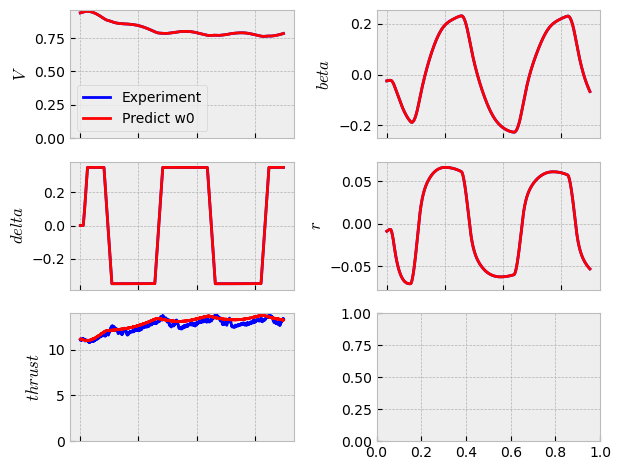

In [124]:
dataframes={'Experiment':test,
           'Predict w0': test_predict_w0,
           }
plot(dataframes=dataframes, keys=['thrust','V','beta','r','delta']);